<a href="https://colab.research.google.com/github/avncalst/drone_cnn/blob/master/quantClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf-nightly
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 453.3MB 34kB/s 
     |████████████████████████████████| 5.9MB 46.7MB/s 
     |████████████████████████████████| 4.2MB 39.2MB/s 
     |████████████████████████████████| 1.3MB 38.6MB/s 
     |████████████████████████████████| 471kB 51.0MB/s 
     |████████████████████████████████| 4.0MB 45.2MB/s 
     |████████████████████████████████| 4.9MB 32.6MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.37.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
     |████████████████████████████████| 174kB 7.9MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# create symbolic link
!ln -s "drive/MyDrive/Colab Notebooks/Tensorflow" "./Tensorflow"
!dir

drive  sample_data  Tensorflow


# 0. Setup Paths + load modules

In [4]:
import tensorflow as tf
import pandas as pd
import imageio
import re
import random
import cv2
import json
import glob
import pathlib
import PIL

from tensorflow.keras.applications import MobileNetV2
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil
import os
import argparse
import ntpath
import psutil
from imutils import paths
import PIL.ImageDraw as ImageDraw




from tensorflow.keras.layers import Permute,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import get_file



# 1. Images

### Convert Donkeycar data files

In [ ]:
# Convert donkeycar images (tub-format) to class-files (left,right,fly,stop)

source = '/home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18'
imag_path = 'Tensorflow/workspace/images/train'

# list_json = glob.glob("/home/avncalst/Dropbox/donkeycar/mycar/data/mccb/tub_7_20-03-18/*.json")
list_json = glob.glob(source + '/*.json')
# print(list_json[0])
df = pd.DataFrame([pd.read_json(list_json[0],typ='series')])
for itx, f in enumerate(list_json):
    # print(itx,f)
    df1 = pd.DataFrame([pd.read_json(f,typ='series')])
    df = df.append(df1,ignore_index=True)
df = df.drop_duplicates()
df.tail()


left = os.path.join(imag_path, 'left')
if not os.path.exists(left):
        os.makedirs(left)
right = os.path.join(imag_path, 'right')
if not os.path.exists(right):
        os.makedirs(right)
fly = os.path.join(imag_path, 'fly')
if not os.path.exists(fly):
        os.makedirs(fly)
stop = os.path.join(imag_path, 'stop')
if not os.path.exists(stop):
        os.makedirs(stop)

column = df['cam/image_array']
clas = df['user/angle']
 

for angle,fil in zip(clas,column):
    # print(angle,fil)
    if int(10*angle) == -3:
        shutil.copy(source + '/' + fil, left)
        # print(fil)
    if int(10*angle) == 3:
        shutil.copy(source + '/' + fil, right)
        # print(fil)
    if int(10*angle) == -9:
        shutil.copy(source + '/' + fil, fly)
        # print(fil)
    if int(10*angle) == 9:
        shutil.copy(source + '/' + fil, stop)
        # print(fil)

df.head()

,cam/image_array,user/angle,user/throttle,user/mode,milliseconds
0,2011_cam-image_array_.jpg,0.9,0.0,user,204983
2,692_cam-image_array_.jpg,-0.9,0.0,user,70527
3,273_cam-image_array_.jpg,-0.9,0.0,user,27813
4,1873_cam-image_array_.jpg,0.3,0.0,user,190917
5,1144_cam-image_array_.jpg,-0.3,0.0,user,116605


### Check image doubles

In [ ]:
# USAGE
# python detect_and_remove.py --dataset dataset
# python detect_and_remove.py --dataset dataset --remove 1
#----------------------------------------------------------------
# remove = -1
remove = 1
#----------------------------------------------------------------

def dhash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))

    # compute the (relative) horizontal gradient between adjacent
    # column pixels
    diff = resized[:, 1:] > resized[:, :-1]

    # convert the difference image to a hash and return it
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

data_dir = 'Tensorflow/workspace/images/train'
data_dir = pathlib.Path(data_dir)
imagePaths = list(data_dir.glob('left/*')) + list(data_dir.glob('right/*')) + list(data_dir.glob('stop/*')) + list(data_dir.glob('fly/*'))

# print(list(data_dir.glob('left/*')))


# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
print("[INFO] computing image hashes...")
# imagePaths = list(paths.list_images(args["dataset"]))
hashes = {}

# loop over our image paths
for imagePath in imagePaths:
    # load the input image and compute the hash
    image = cv2.imread(str(imagePath))
    h = dhash(image)
    

    # grab all image paths with that hash, add the current image
    # path to it, and store the list back in the hashes dictionary
    p = hashes.get(h, [])
    p.append(imagePath)
    hashes[h] = p

# loop over the image hashes
for (h, hashedPaths) in hashes.items():
	# check to see if there is more than one image with the same hash
    if len(hashedPaths) > 1:
		# check to see if this is a dry run
        if remove <= 0:
            # initialize a montage to store all images with the same
            # hash
            montage = None

            # loop over all image paths with the same hash
            for p in hashedPaths:
                # load the input image and resize it to a fixed width
                # and height
                image = cv2.imread(str(p))
                image = cv2.resize(image, (150, 150))

                # if our montage is None, initialize it
                if montage is None:
                    montage = image

                # otherwise, horizontally stack the images
                else:
                    montage = np.hstack([montage, image])

            # show the montage for the hash
            print("[INFO] hash: {}".format(h))
            montage = cv2.cvtColor(montage, cv2.COLOR_BGR2RGB)
            img = PIL.Image.fromarray(montage)
            img.show()

 
		# otherwise, we'll be removing the duplicate images
        else:
			# loop over all image paths with the same hash *except*
			# for the first image in the list (since we want to keep
			# one, and only one, of the duplicate images)
            for p in hashedPaths[1:]:
                os.remove(p)
            print("[INFO] doubles removed...")
print("[INFO] finished")

[INFO] computing image hashes...
[INFO] finished


### populate image classes and check images

In [ ]:
data_source = 'Tensorflow/workspace/images/source/'
data_left = 'Tensorflow/workspace/images/train/left/'
data_right = 'Tensorflow/workspace/images/train/right/'
data_stop = 'Tensorflow/workspace/images/train/stop/'
data_fly = 'Tensorflow/workspace/images/train/fly/'
src = {'source':data_source,'left':data_left,'right':data_right,'stop':data_stop,'fly':data_fly}

#========================================================
dir_select = 'right' # select:left, right,fly,stop,source
#========================================================

imagePats = list(paths.list_images(src[dir_select]))
ntpath.basename(src[dir_select])


width = 160
height = 120
i = 0



for imagePat in imagePats:
    head, tail = ntpath.split(str(imagePat))
    print(i,head)
    print(i,tail)
    i+=1
    im = PIL.Image.open(str(imagePat))
    im = im.resize((width, height), PIL.Image.ANTIALIAS)
    im.save(str(imagePat))
    draw = ImageDraw.Draw(im) 
    draw.line((53,0, 53,120), fill=128,width=3)
    draw.line((106,0, 106,120), fill=128,width=3)
    draw.line((0,40, 160,40), fill=128,width=3)
    draw.line((0,80, 160,80), fill=128,width=3)
    draw.line
    im.show()
    
    while True:
        txt = input("f,r,l,s -select dir,n -no action,b -break,d -delete")
        if txt == dir_select[:1]:
            print('cannot move to working dir')
        else:
            break
        
    if txt == 'f':
        shutil.move(str(imagePat), os.path.join(data_fly, tail))
        print('file moved to folder fly')
    if txt == 'l':
        shutil.move(str(imagePat), os.path.join(data_left, tail))
        print('file moved to folder left')
    if txt == 'r':
        shutil.move(str(imagePat), os.path.join(data_right, tail))
        print('file moved to folder right')        
    if txt == 's':
        shutil.move(str(imagePat), os.path.join(data_stop, tail))
        print('file moved to folder stop')
    if txt == 'n':
        pass
    if txt == 'b':
        break
    if txt == 'd':
        os.remove(str(imagePat))
        print('file deleted')


    # PIL image.show() yields a new process. To stop kill process with name display
    for proc in psutil.process_iter(): # traverse the current process
        # print(proc.name)
        if proc.name() == "display": # If the name of the process is display
            proc.kill() # Close the process

for proc in psutil.process_iter(): # traverse the current process
        # print(proc.name)
        if proc.name() == "display": # If the name of the process is display
            proc.kill() # Close the process
    
    

space/images/train/right
193 1772_cam-image_array_.jpg
194 Tensorflow/workspace/images/train/right
194 1852_cam-image_array_.jpg
195 Tensorflow/workspace/images/train/right
195 1704_cam-image_array_.jpg
196 Tensorflow/workspace/images/train/right
196 right0272.jpg
197 Tensorflow/workspace/images/train/right
197 1925_cam-image_array_.jpg
198 Tensorflow/workspace/images/train/right
198 right0140.jpg
199 Tensorflow/workspace/images/train/right
199 right0088.jpg
200 Tensorflow/workspace/images/train/right
200 right0270.jpg
201 Tensorflow/workspace/images/train/right
201 right0282.jpg
202 Tensorflow/workspace/images/train/right
202 right0299.jpg
203 Tensorflow/workspace/images/train/right
203 1859_cam-image_array_.jpg
204 Tensorflow/workspace/images/train/right
204 right0279.jpg
205 Tensorflow/workspace/images/train/right
205 right0289.jpg
206 Tensorflow/workspace/images/train/right
206 1757_cam-image_array_.jpg
207 Tensorflow/workspace/images/train/right
207 right0084.jpg
208 Tensorflow/wo

### Define data directory containing class data-files

1857


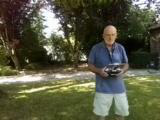

In [5]:
data_dir = 'Tensorflow/workspace/images/train'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
imag = list(data_dir.glob('left/*'))
PIL.Image.open(str(imag[0]))


# 2. Train & Validation data

In [6]:
batch_size = 32
img_height = 224
img_width = 224
# generates data and labels (0,1,2,3) from data directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='rgb',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='rgb',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1857 files belonging to 4 classes.
Using 1486 files for training.
Found 1857 files belonging to 4 classes.
Using 371 files for validation.


In [7]:
# Normalization utils
def normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

In [8]:
train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)
# check normalization
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
first_label = labels_batch[0]
print(np.min(first_image), np.max(first_image))
print(first_label)

# or use:

# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(train_ds))
# first_image = image_batch[0]
# first_label = labels_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))
# print(first_label)

0.0 0.9993497
tf.Tensor(0, shape=(), dtype=int32)


# 3. Model Quantized Transfer Learning

In [9]:
def get_training_model():
    EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
    EXTRACTOR.trainable = True
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(4, activation="softmax")(class_head)
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)
    
    return classifier

# 4. Train model

In [10]:
quant_model = get_training_model()
q_quant_model = tfmot.quantization.keras.quantize_model(quant_model)
q_quant_model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(1e-5),
                          metrics=["accuracy"])
start = time.time()
history = q_quant_model.fit(train_ds,
              validation_data=val_ds,
              epochs=30)
end = time.time()-start
print("Model takes {} seconds to train ",end)

9412608/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
47/47 [==============================] - 423s 9s/step - loss: 1.2750 - accuracy: 0.4495 - val_loss: 1.1630 - val_accuracy: 0.5445
Epoch 2/30
47/47 [==============================] - 343s 7s/step - loss: 0.9224 - accuracy: 0.6528 - val_loss: 1.0444 - val_accuracy: 0.5903
Epoch 3/30
47/47 [==============================] - 340s 7s/step - loss: 0.7311 - accuracy: 0.7429 - val_loss: 0.9286 - val_accuracy: 0.6415
Epoch 4/30
47/47 [==============================] - 339s 7s/step - loss: 0.6264 - accuracy: 0.7900 - val_loss: 0.8252 - val_accuracy: 0.6873
Epoch 5/30
47/47 [==============================] - 337s 7s/step - loss: 0.5096 - accuracy: 0.8311 - val_loss: 0.7587 - val_accuracy: 0.7332
Epoch 6/30
47/47 [==============================] - 335s 7s/step - loss: 0.4468 - accuracy: 0.8486 - val_loss: 0.7207 - val_accuracy: 0.7601
Epoch 7/30
47/47 [==============================] - 336s 7s/step - loss: 0.3936 - accuracy: 0.8688 - val_loss: 0.6552 - val_accuracy: 0.7736
Epoch 8/30
47

# 5. Convert Keras model to Tflite & save model

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_quant_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmp8015rwa_/assets


INFO:tensorflow:Assets written to: /tmp/tmp8015rwa_/assets


In [12]:
with open('w_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

  !ls -lh w_tflite_model.tflite

-rw-r--r-- 1 root root 3.3M May 12 18:59 w_tflite_model.tflite


# 6. Compile via edgetpu_compiler

In [ ]:
!edgetpu_compiler ./Tensorflow/tflite/w_tflite_model.tflite -o ./Tensorflow/tflite

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 2575 ms.

Input model: ./Tensorflow/tflite/w_tflite_model.tflite
Input size: 3.21MiB
Output model: ./Tensorflow/tflite/w_tflite_model_edgetpu.tflite
Output size: 3.40MiB
On-chip memory used for caching model parameters: 3.29MiB
On-chip memory remaining for caching model parameters: 3.60MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: ./Tensorflow/tflite/w_tflite_model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 70
Number of operations that will run on CPU: 2
See the operation log file for individual operation detail